In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.cm as cm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

from PIL import Image

from brainiac.loader import ADNIClassificationDataset
from brainiac.utils import load_model
from brainiac.models import SimpleCNN, AlexNet3D
from brainiac.grad_cam import GradCAM

In [4]:
import cv2

In [5]:
def from_3d_img_to_frames(img):
    img = img.squeeze(0).squeeze(0)
    frames = [Image.fromarray(np.uint8(img.numpy()[i] * 255)) for i in range(img.shape[0])]
    frames = [fr.convert('P', palette = Image.ADAPTIVE) for fr in frames]
    return frames

In [6]:
def save_gif(images, path, duration=0.1):
    images[0].save(path, save_all=True, append_images=images[1:],
                   optimize=False, duration=duration, loop=0)

In [7]:
def make_regions_from(model, images, target_layers, target_class=None, mode='3D'):
    
    gcam = GradCAM(model, target_layers, mode=mode)
    
    probs, ids = gcam.forward(images)
    
    if target_class is None:
        target_class = ids[0, 0]
        
    ids_ = torch.LongTensor([[target_class]] * len(images))
    gcam.backward(ids=ids_)
    
    regions = gcam.generate(target_layer=target_layers[-1])
    
    gcam.remove_hook()
    return regions

In [8]:
def get_gradcam(gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    
    return gcam

In [9]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

# Resnet

In [10]:
from torchvision import models, transforms

In [11]:
model = models.resnet152(pretrained=True)
_ = model.eval()

In [12]:
image, raw_image = preprocess('image02.png')
images = image.unsqueeze(0)

In [13]:
regions = make_regions_from(model, images, target_layers=['layer2'], mode='2D')
gcam = get_gradcam(1 - regions[0], raw_image)
gcam = np.uint8(gcam)[0]

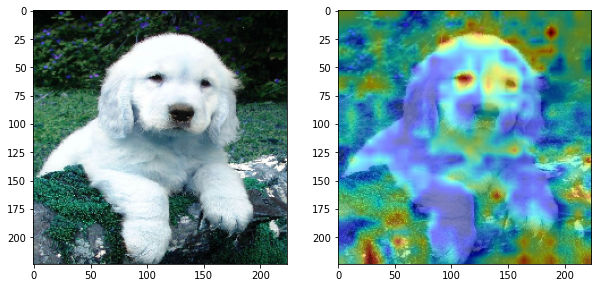

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(raw_image)
ax[1].imshow(gcam)

plt.show()

# Our model

In [15]:
path = '/home/ADNI-processed/data.csv'
df = pd.read_csv(path)
dataset = ADNIClassificationDataset(df)

raw_image = np.uint8(dataset[0][0][0] * 255)
raw_image = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in raw_image]

images = dataset[0][0].unsqueeze(0)

In [16]:
# model = AlexNet3D(num_classes=2)
# model, _ = load_model(model, 'trained_model/AlexNet3D/CN-AD_Adam_100_4_0.001_1e-05/model_epoch0.pth')

model = SimpleCNN(num_classes=2)
model, _ = load_model(model, 'trained_model/CNN/CN-AD_Adam_100_4_0.001_1e-05/model_epoch7.pth')
_ = model.eval()

In [25]:
regions = make_regions_from(model, images, target_layers=['conv'], mode='3D')

In [30]:
i = 120
gcam = get_gradcam(1 - regions[0, 0, i], raw_image[i])
gcam = np.uint8(gcam)

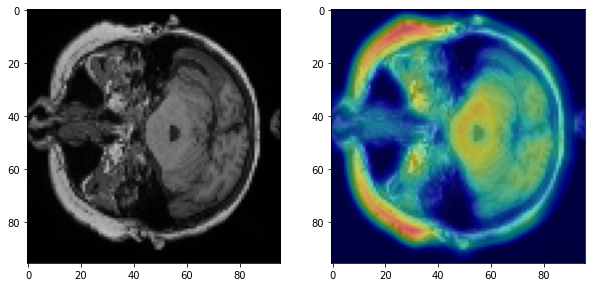

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(raw_image[i])
ax[1].imshow(gcam)

plt.show()